# Maritime Trade: Train 2019 XGBoost GPU
## Hyperopt Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install xgboost==1.5.2
!pip install eli5
!pip install shap
import os
import random
import numpy as np
import warnings
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor, plot_importance
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import csv
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import joblib
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 
from eli5.sklearn import PermutationImportance 
import webbrowser
from eli5.formatters import format_as_dataframe
import shap
warnings.filterwarnings('ignore')
my_dpi = 96
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 999 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 173.6 MB 7.2 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 35.5 MB/s 
     |████████████████████████████████| 133 kB 82.8 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=d9e98c18a077d0be8178e6cee6f7d67078f29150b35f711652fabdb6365defa2
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    F

In [ ]:
# Set seed 
seed_value = 42
os.environ['xgbGPU_train19test20'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633772, 20)


In [ ]:
# Convert 
df['DateTime']= pd.to_datetime(df['DateTime']) 
df['DateTime_YearWeek'] = df['DateTime'].dt.strftime('%Y-w%U')

# Drop time 
df = df.drop(['DateTime'], axis=1)

In [ ]:
# Filter df to 2019
df1 = df[df['Year'] == 2019]

# Filter df to 2020
df2 = df[df['Year'] == 2020]

# Drop year variable
df1 = df1.drop(['Year'], axis=1)
df2 = df2.drop(['Year'], axis=1)

del df

In [ ]:
# Prepare 2019 for partitioning data
X = df1.drop(['Metric_Tons'], axis=1)
y = df1.loc[:, ['Metric_Tons']]

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.DateTime_YearWeek,
                                                    random_state=seed_value)

In [ ]:
# Drop variable used to stratify sets
X_train = X_train.drop(['DateTime_YearWeek'], axis=1)
X_test = X_test.drop(['DateTime_YearWeek'], axis=1)

In [ ]:
# Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(mn.transform(X_test), columns=X_test.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions


## 100 Trials 10-Fold Cross Validation

In [ ]:
# Define the number of trials
NUM_EVAL = 100

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=seed_value)

xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.75),
    'gamma': hp.uniform('gamma', 0, 9),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 0.3),
    'reg_alpha': hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.05, 0.5),  
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 10, 
                                                                dtype=int))
    }

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):
    """XGBoost HPO"""
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBRegressor(
        objective='reg:squarederror',
        booster='gbtree', 
        tree_method='gpu_hist',    
        scale_pos_weight=1,
        use_label_encoder=False,
        random_state=seed_value,        
        verbosity=0,
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train,
                              scoring='neg_root_mean_squared_error',
                              cv=kfolds)
    run_time = timer() - start

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])
    
    return {'loss': rmse, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'XGB_HPO_train19test19_100_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate=np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-13 00:49:50.708269
100%|██████████| 100/100 [5:50:30<00:00, 210.30s/it, best loss: 11.376416734257052]
Start Time           2022-02-13 00:49:50.708269
End Time             2022-02-13 06:40:21.119814
5:50:30


In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key=lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 11.376416734257052, 'params': {'colsample_bylevel': 0.4187955144635411, 'colsample_bytree': 0.9691370445754729, 'gamma': 5.9541691670426165, 'learning_rate': 0.2722606002969347, 'max_depth': 12, 'min_child_weight': 0, 'n_estimators': 481, 'reg_alpha': 12, 'reg_lambda': 1.860060463896499, 'subsample': 0.6299265405016402}, 'iteration': 89, 'train_time': 629.779493899001, 'status': 'ok'}, {'loss': 11.384447487375924, 'params': {'colsample_bylevel': 0.46140425786742545, 'colsample_bytree': 0.9351728114281412, 'gamma': 6.103262193641414, 'learning_rate': 0.264707749696851, 'max_depth': 12, 'min_child_weight': 0, 'n_estimators': 495, 'reg_alpha': 12, 'reg_lambda': 2.1129739310180353, 'subsample': 0.5821320284929369}, 'iteration': 87, 'train_time': 643.1957710830029, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_train19test19_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,
                                random_state=seed_value,
                                verbosity=0, 
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_train19test19_100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_train19test19_100_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Train 2019 Test 2019 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

Model Metrics for XGBoost HPO Train 2019 Test 2019 100 GPU trials
MAE train: 4.067, test: 6.973
MSE train: 73.132, test: 218.906
RMSE train: 8.552, test: 14.795
R^2 train: 0.891, test: 0.672


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, 
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 218.90556 MSE on the test set.
This was achieved after 89 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_train19test19_100_GPU.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

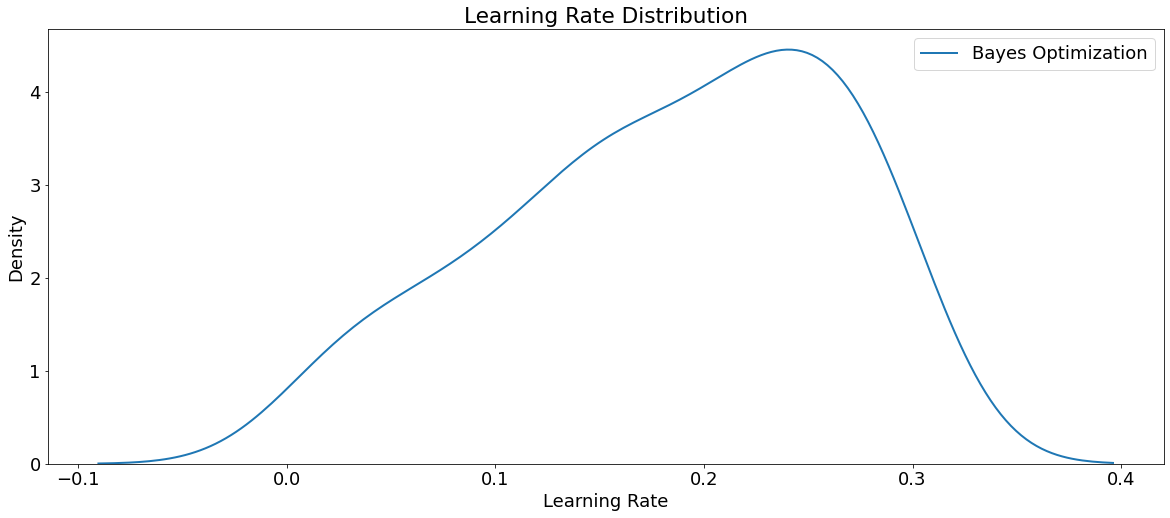

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

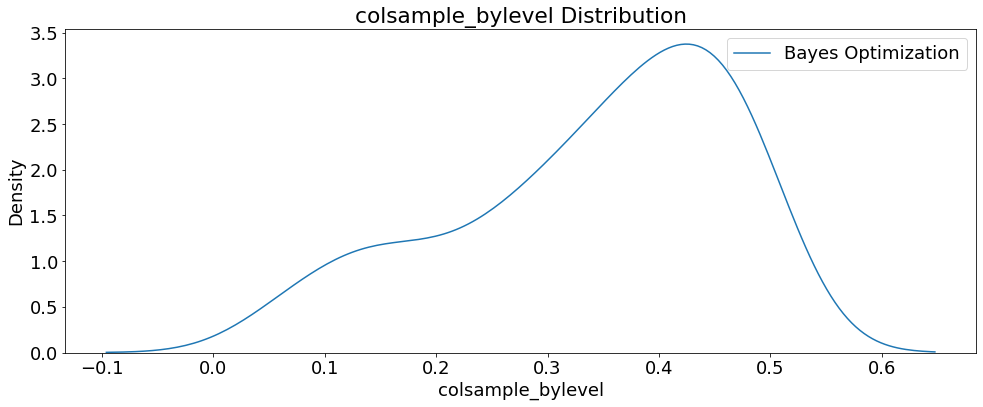

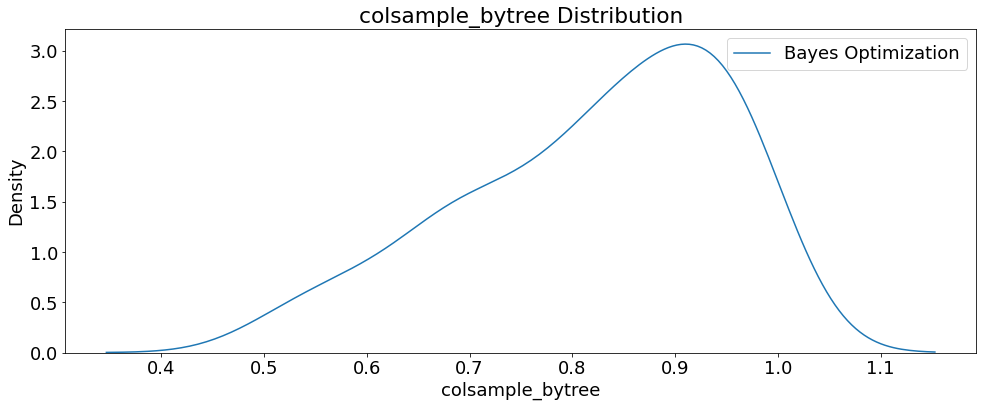

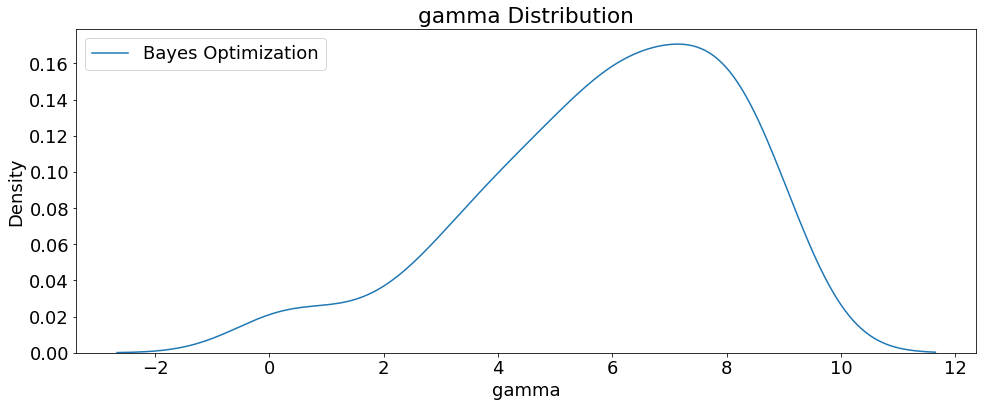

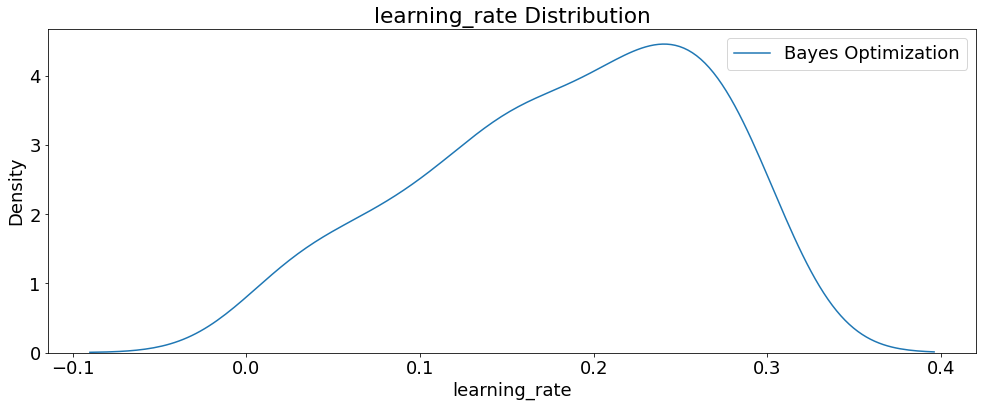

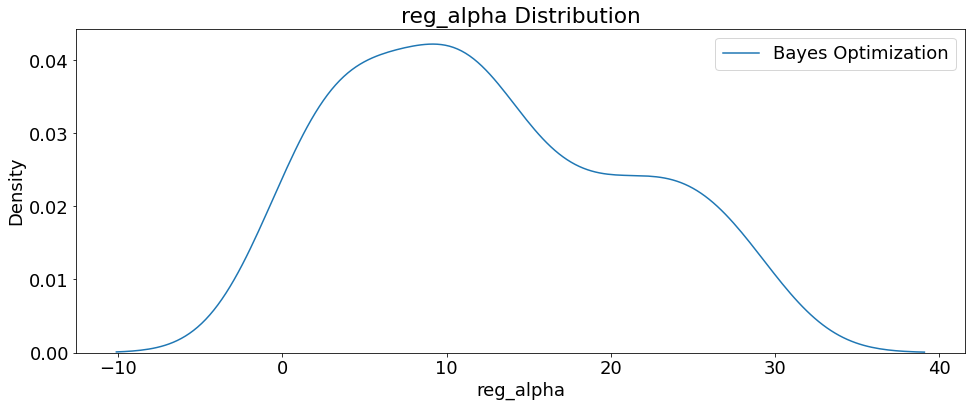

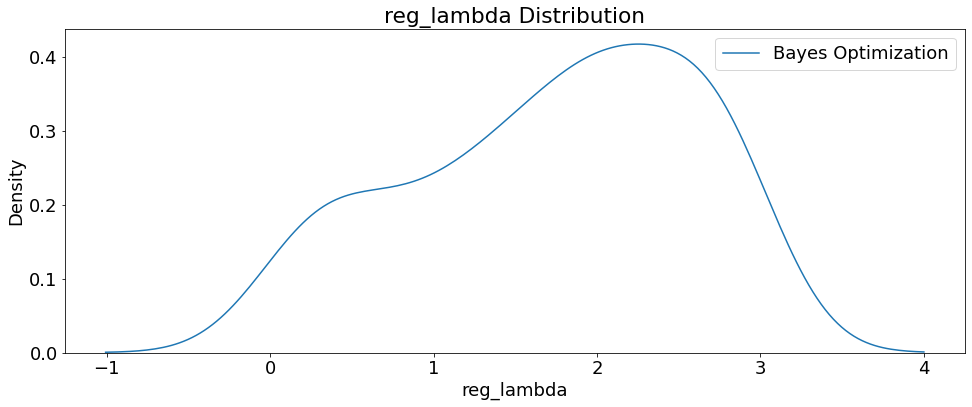

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

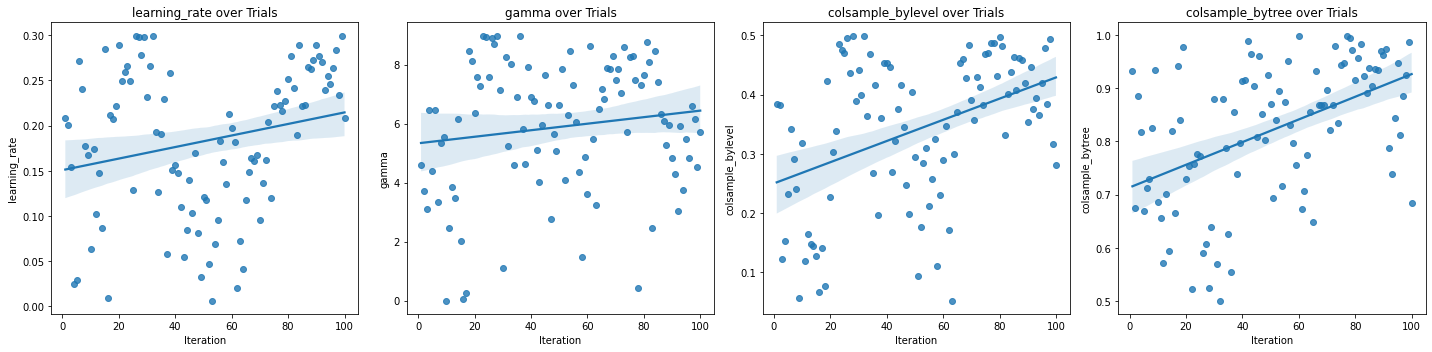

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
  title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

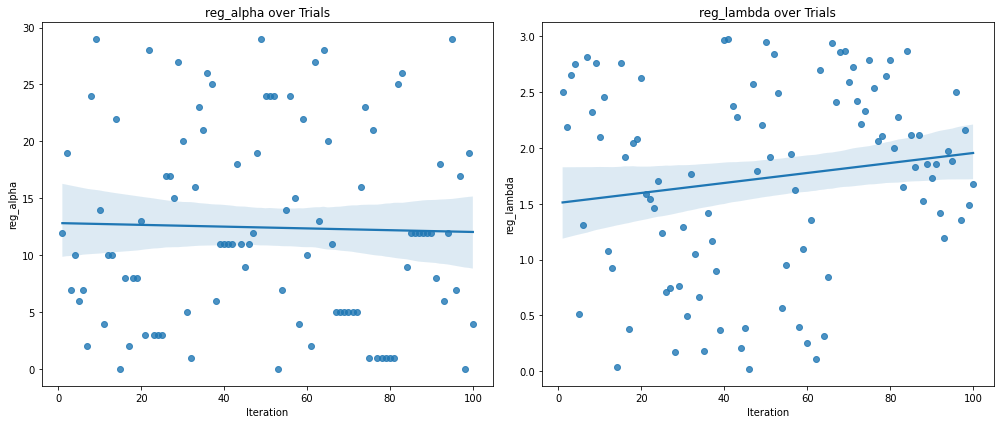

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
  title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


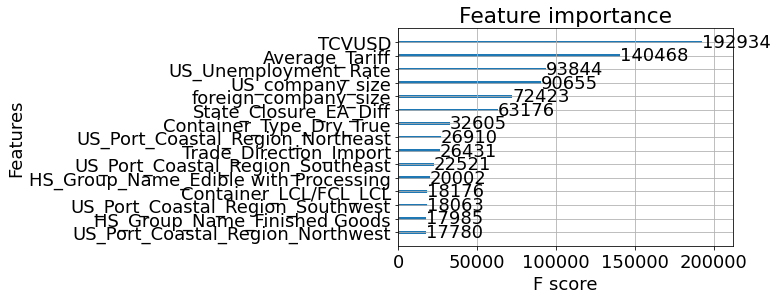

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train19test19_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

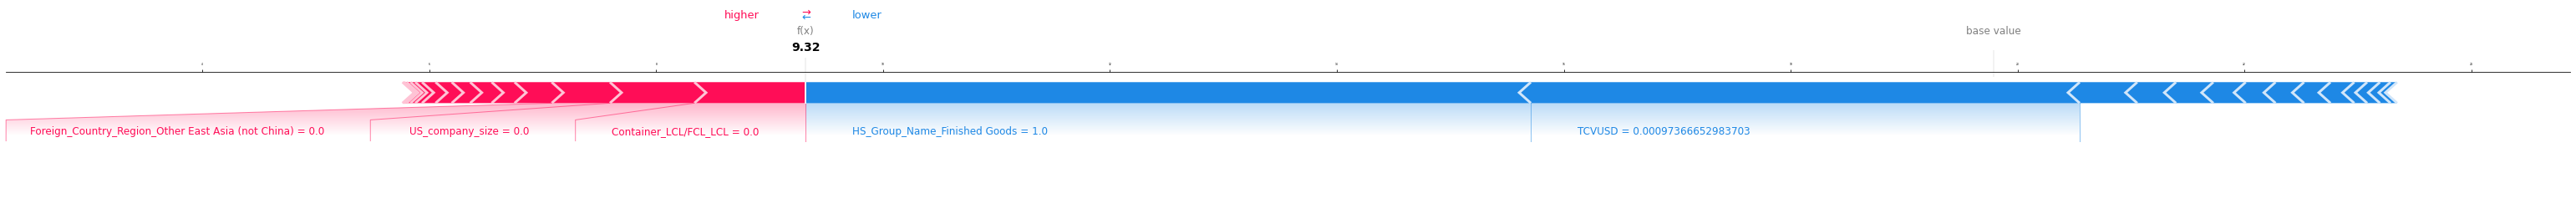

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_100_GPU_train19test19_ShapForcePlot_TrainSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

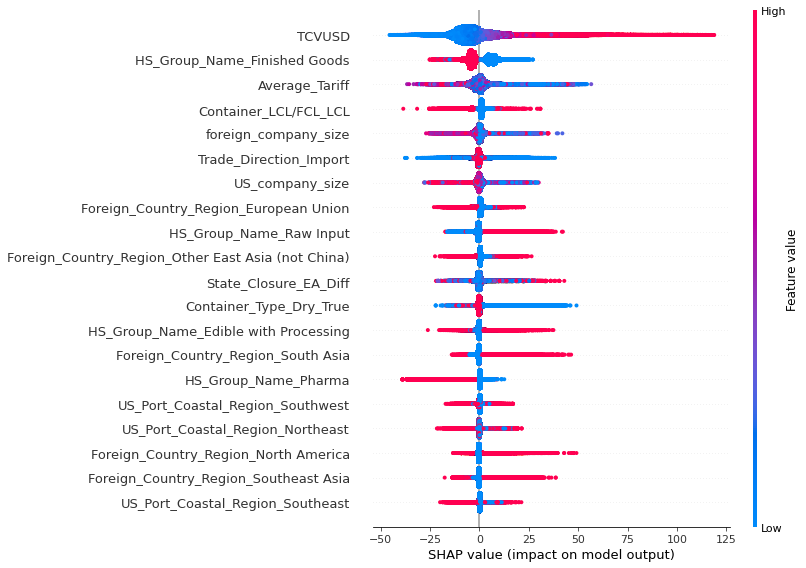

In [ ]:
# Training Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGBoost_HPO_100_GPU_train19test19_ShapSummary_TrainSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

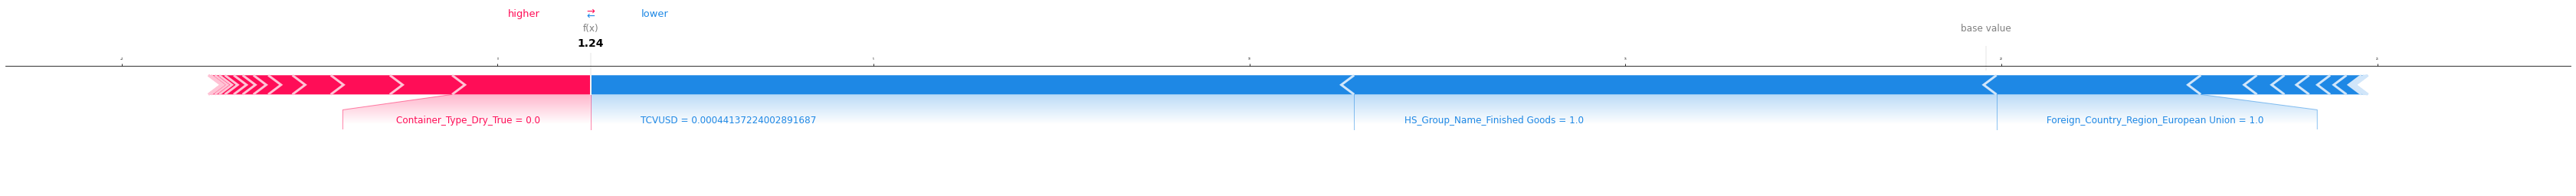

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True, figsize=(60,3)).savefig('XGBoost_HPO_100_GPU_train19test19_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

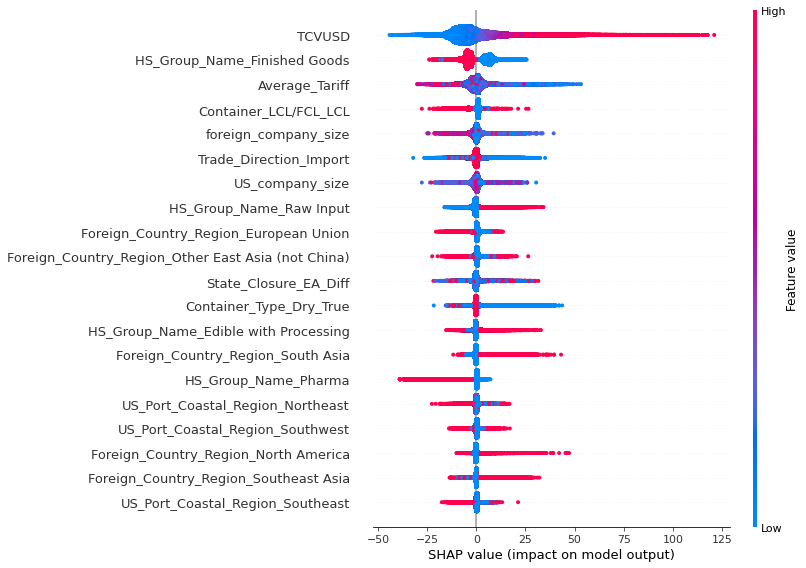

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGB_HPO_300_GPU_train19test19_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train19test19_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train19test19_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj 

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train19test19_HPO_100_GPU_WeightsExplain.csv', 
           index=False)
exp

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  1.072495  0.003418
1                                      Average_Tariff  0.432659  0.001701
2                        HS_Group_Name_Finished Goods  0.235156  0.001379
3                              Trade_Direction_Import  0.176431  0.001281
4                             HS_Group_Name_Raw Input  0.125516  0.000702
5                               State_Closure_EA_Diff  0.074109  0.000752
6                   Foreign_Country_Region_South Asia  0.061765  0.000414
7                             Container_Type_Dry_True  0.059611  0.000773
8                                foreign_company_size  0.058250  0.000390
9               Foreign_Country_Region_European Union  0.046632  0.000279
10               HS_Group_Name_Edible with Processing  0.045861  0.000331
11  Foreign_Country_Region_Other East Asia (not Ch...  0.045242  0.000840
12                   US_Port_Coastal_Region_Northeast  0.039525  0.000361
13                                    US_company_size  0.035363  0.001028
14                              Container_LCL/FCL_LCL  0.034359  0.000501
15               Foreign_Country_Region_North America  0.032048  0.000267
16              Foreign_Country_Region_Southeast Asia  0.031289  0.000337
17                               HS_Group_Name_Pharma  0.029350  0.000112
18               Foreign_Country_Region_South America  0.027576  0.000417
19                   US_Port_Coastal_Region_Southeast  0.025216  0.000366

### Test trained 2019 model on 2020

In [ ]:
# Prepare 2020 to fit model train on 2019
X_test1 = df2.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y_test1 = df2['Metric_Tons']

In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2019 Test 2020')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2019 Test 2020
MAE train: 13.378, test: 3.930
MSE train: 42646.878, test: 57.289
RMSE train: 206.511, test: 7.569
R^2 train: 0.877, test: 0.908


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


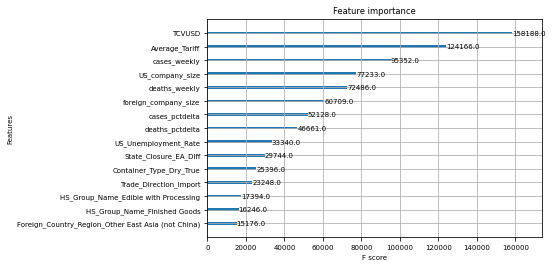

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGB_HPO_train19test20_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

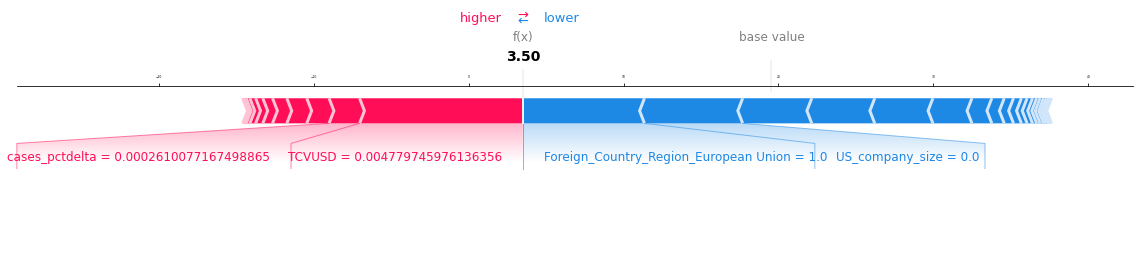

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_100_GPU_train19test20_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

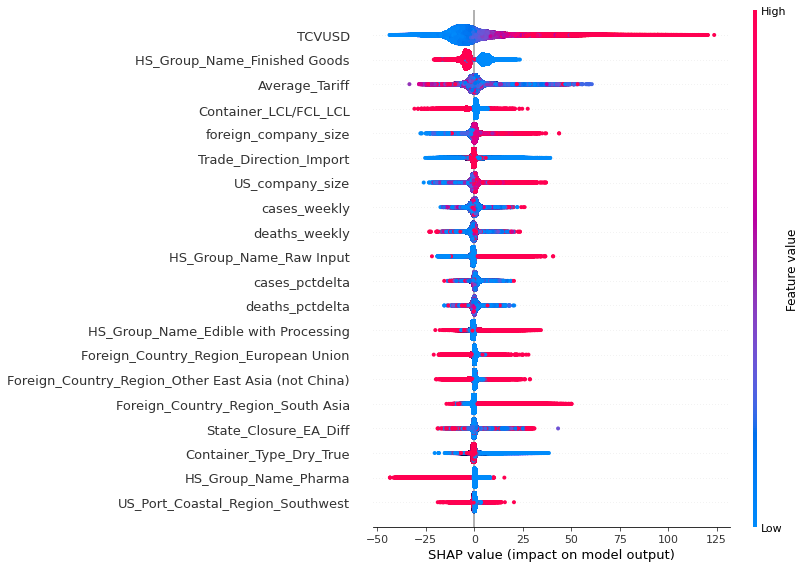

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_100_GPU_train19test20_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)                                                                    

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train19test20_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train19test20_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_train.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train19test20_HPO_100_GPU_WeightsExplain.csv', 
           index=False)
exp

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  1.202817  0.000653
1                                      Average_Tariff  0.524612  0.000595
2                        HS_Group_Name_Finished Goods  0.230078  0.000219
3                                        cases_weekly  0.205336  0.000377
4                              Trade_Direction_Import  0.173661  0.000359
5                                       deaths_weekly  0.156881  0.000275
6                                     deaths_pctdelta  0.154484  0.000140
7                                     US_company_size  0.147159  0.000339
8                             HS_Group_Name_Raw Input  0.123811  0.000350
9                                foreign_company_size  0.122660  0.000203
10                                     cases_pctdelta  0.122354  0.000265
11                              State_Closure_EA_Diff  0.075568  0.000235
12                  Foreign_Country_Region_South Asia  0.072652  0.000238
13               HS_Group_Name_Edible with Processing  0.071522  0.000238
14                            Container_Type_Dry_True  0.066136  0.000095
15              Foreign_Country_Region_European Union  0.066012  0.000082
16  Foreign_Country_Region_Other East Asia (not Ch...  0.053291  0.000110
17              Foreign_Country_Region_Southeast Asia  0.041481  0.000098
18                               US_Unemployment_Rate  0.040830  0.000087
19                               HS_Group_Name_Pharma  0.038122  0.000096

## 300 Trials 10-Fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 300

In [ ]:
# File to save first results
out_file = 'XGB_HPO_train19test19_300_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate=np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-14 01:08:00.360973
100%|██████████| 300/300 [19:45:18<00:00, 237.06s/it, best loss: 11.237319701751629]
Start Time           2022-02-14 01:08:00.360973
End Time             2022-02-14 20:53:18.463500
19:45:18


In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key=lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 11.237319701751629, 'params': {'colsample_bylevel': 0.4780625679662488, 'colsample_bytree': 0.9361526248666536, 'gamma': 6.8918104516127725, 'learning_rate': 0.17964990675981266, 'max_depth': 12, 'min_child_weight': 2, 'n_estimators': 445, 'reg_alpha': 0, 'reg_lambda': 1.9993818388289566, 'subsample': 0.7033340078009602}, 'iteration': 282, 'train_time': 582.9547960619966, 'status': 'ok'}, {'loss': 11.256157992444322, 'params': {'colsample_bylevel': 0.4161061829475779, 'colsample_bytree': 0.9984372613612924, 'gamma': 7.344266997017295, 'learning_rate': 0.11761760489026092, 'max_depth': 12, 'min_child_weight': 0, 'n_estimators': 482, 'reg_alpha': 12, 'reg_lambda': 2.1583621935768202, 'subsample': 0.6819251117603152}, 'iteration': 201, 'train_time': 616.6117291259943, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_train19test19_300_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,
                                random_state=seed_value,
                                verbosity=0, 
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_train19test19_300_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_train19test19_300_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Train 2019 Test 2019 300 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

Model Metrics for XGBoost HPO Train 2019 Test 2019 300 GPU trials
MAE train: 4.160, test: 6.808
MSE train: 78.448, test: 209.785
RMSE train: 8.857, test: 14.484
R^2 train: 0.883, test: 0.686


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, 
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 209.78482 MSE on the test set.
This was achieved after 282 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_train19test19_300_GPU.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

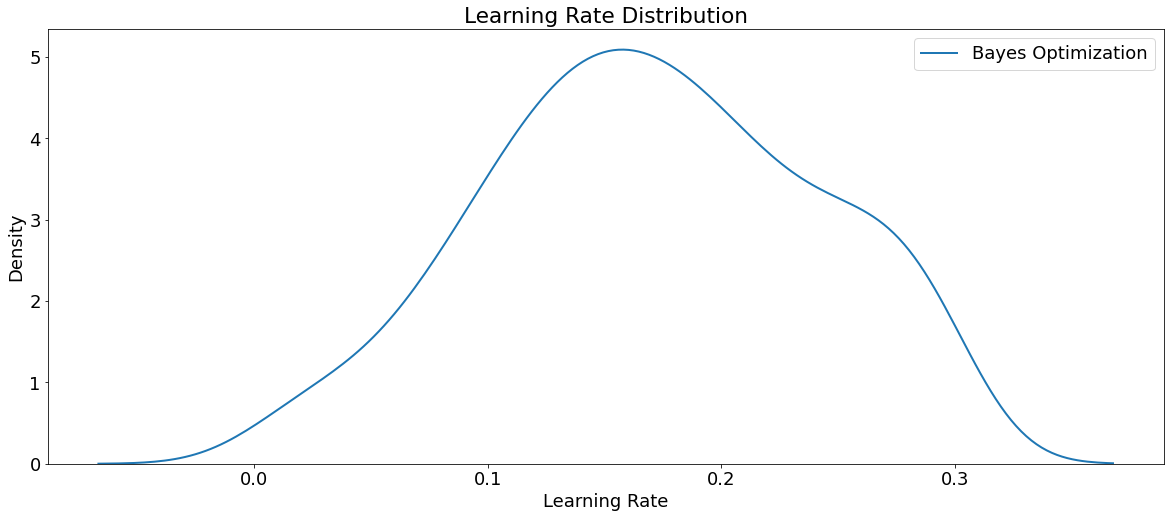

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

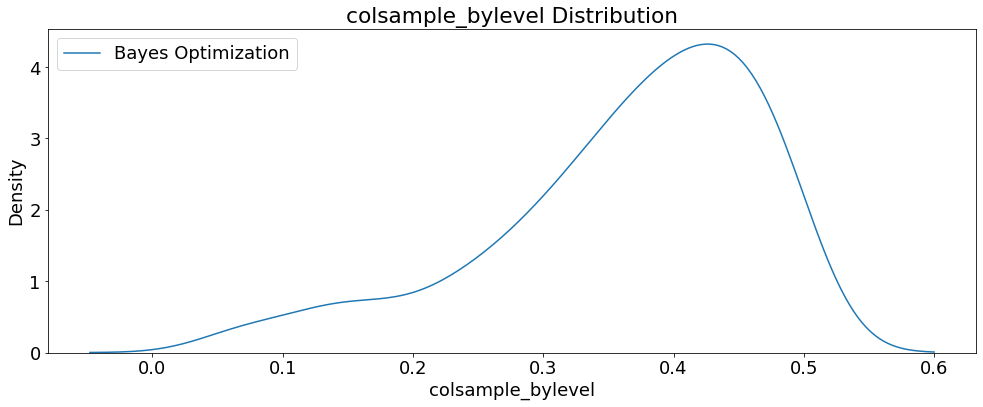

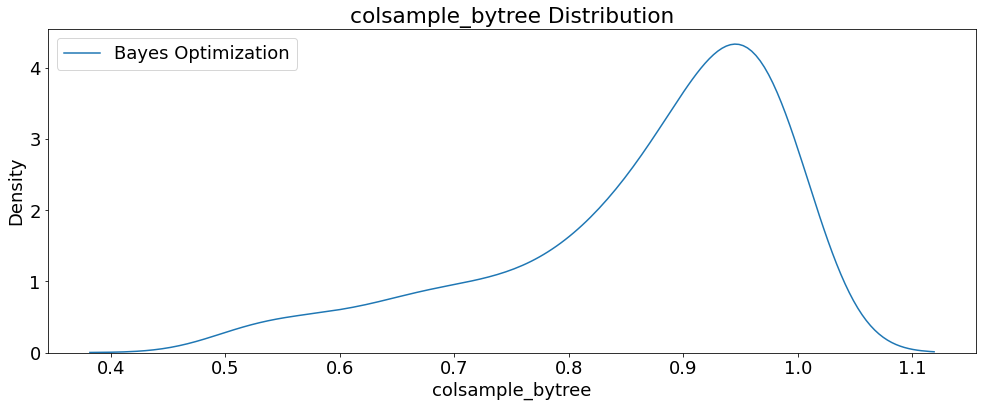

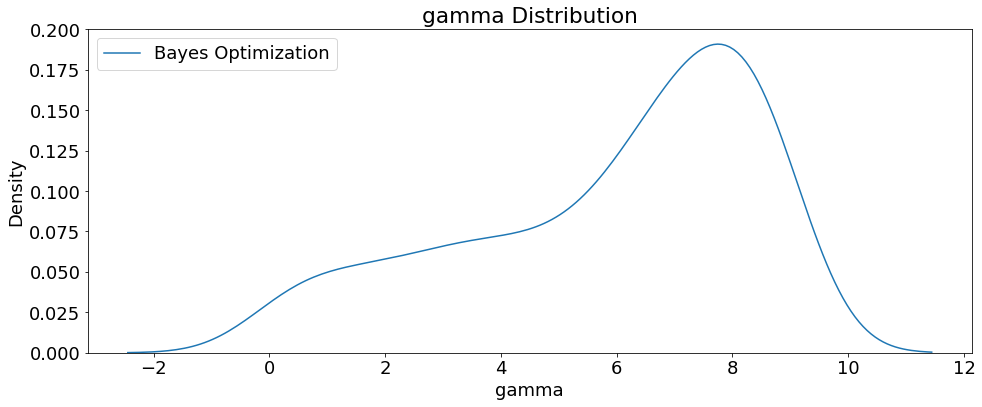

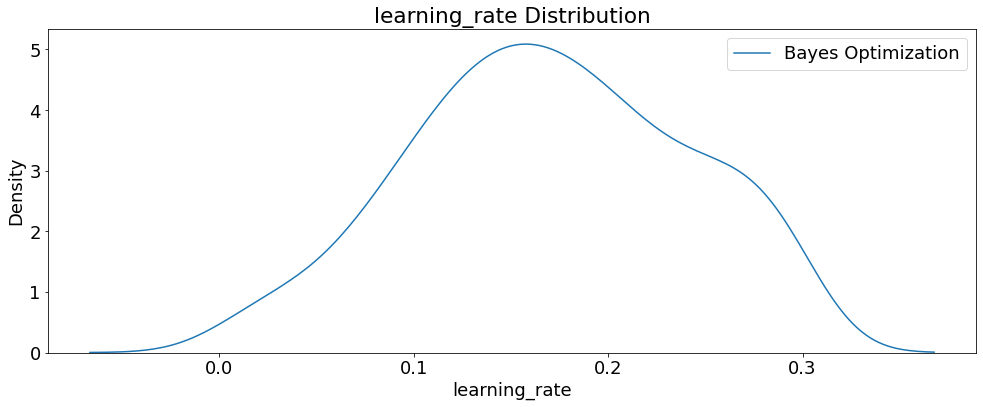

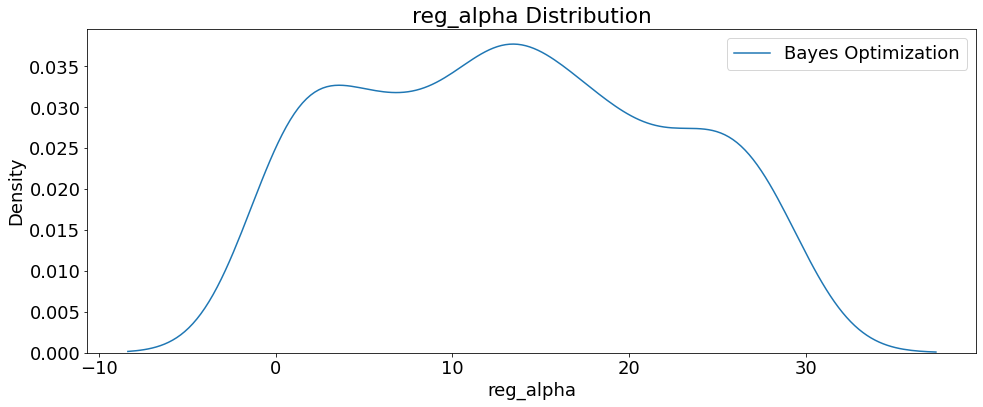

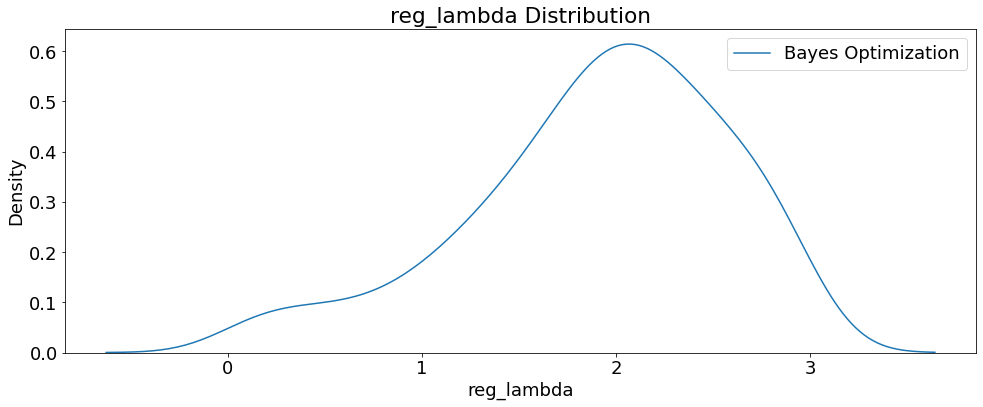

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

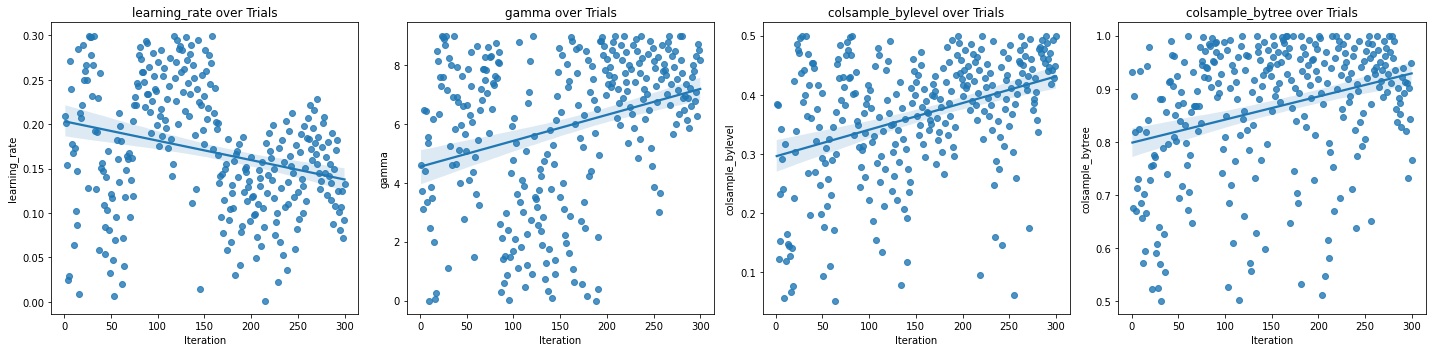

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
    # Scatterplot
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

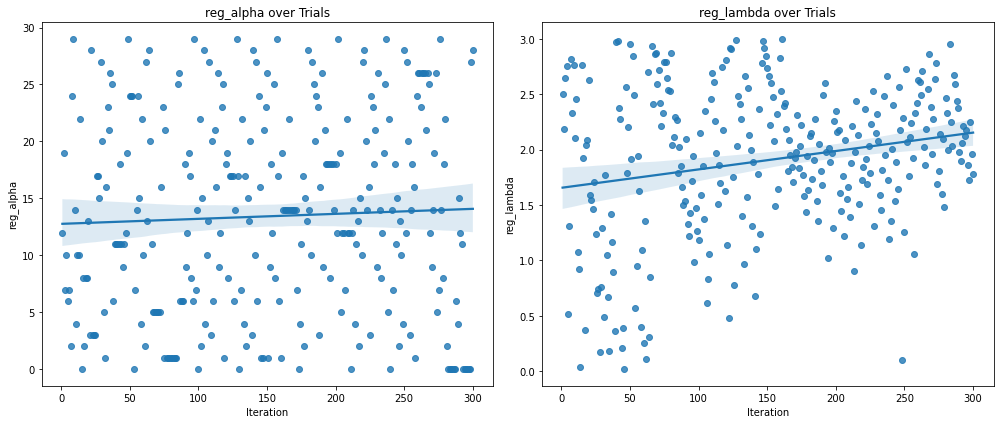

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
  title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


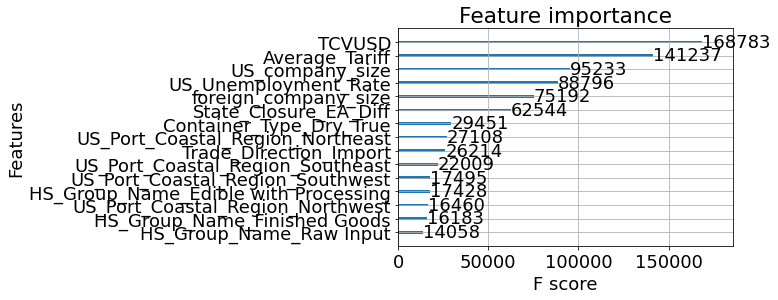

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGB_HPO_train19test19_300_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

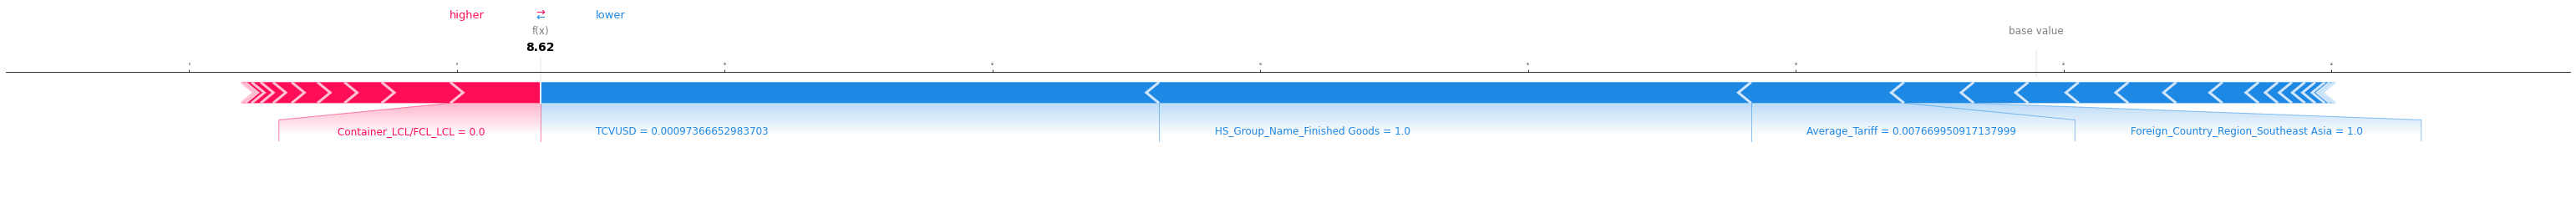

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_300_GPU_train19test19_ShapForcePlot_TrainSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

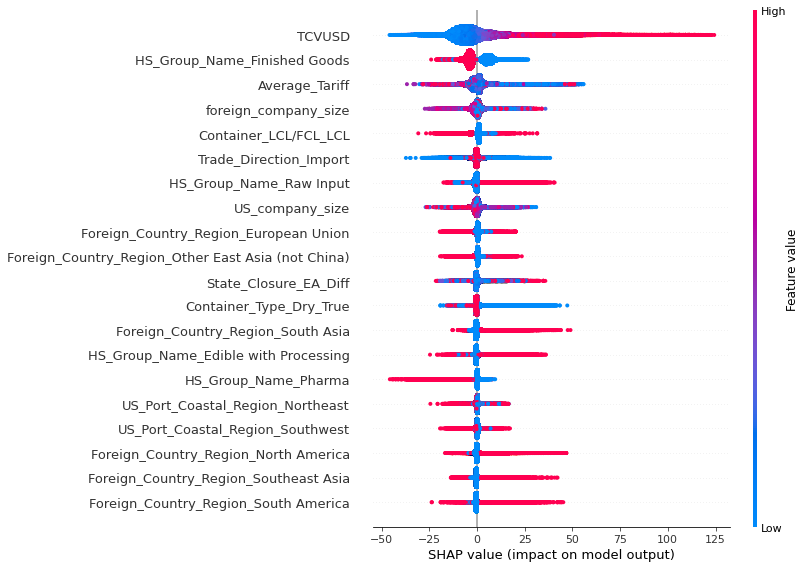

In [ ]:
# Training Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train19test19_ShapSummary_TrainSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

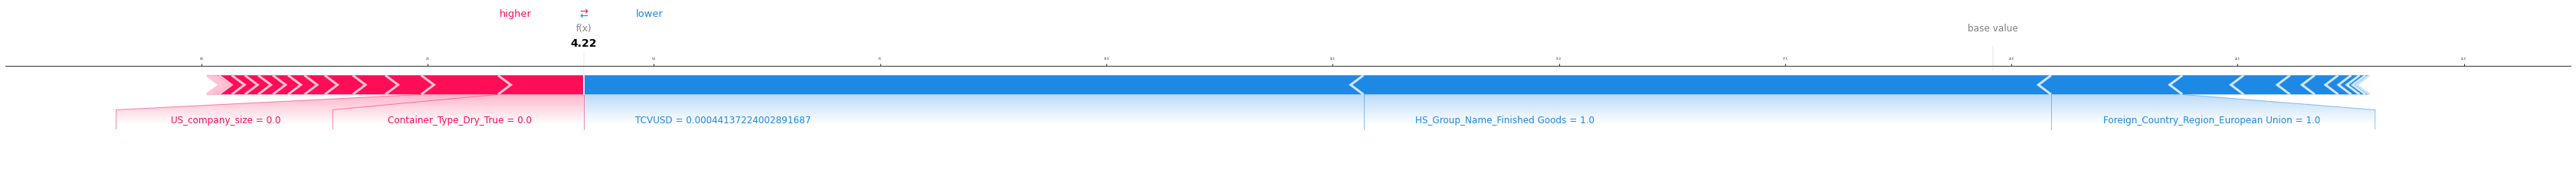

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True, figsize=(60,3)).savefig('XGBoost_HPO_300_GPU_train19test19_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

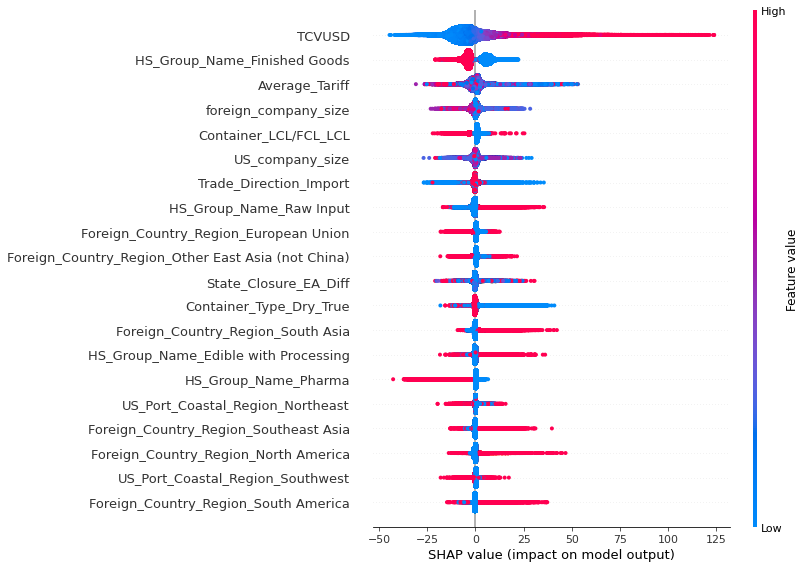

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train19test19_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train19test19_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train19test19_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj 

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train19test19_HPO_300_GPU_WeightsExplain.csv', 
           index=False)

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  1.055732  0.004515
1                                      Average_Tariff  0.406868  0.000949
2                        HS_Group_Name_Finished Goods  0.161128  0.000919
3                              Trade_Direction_Import  0.157703  0.000802
4                             HS_Group_Name_Raw Input  0.138768  0.000866
5                               State_Closure_EA_Diff  0.074576  0.000416
6                             Container_Type_Dry_True  0.058450  0.000898
7                   Foreign_Country_Region_South Asia  0.057099  0.000331
8                                foreign_company_size  0.055112  0.000594
9   Foreign_Country_Region_Other East Asia (not Ch...  0.039723  0.000447
10               HS_Group_Name_Edible with Processing  0.037212  0.000305
11                   US_Port_Coastal_Region_Northeast  0.035407  0.000356
12              Foreign_Country_Region_European Union  0.035087  0.000290
13               Foreign_Country_Region_North America  0.032595  0.000133
14                               HS_Group_Name_Pharma  0.032125  0.000220
15                              Container_LCL/FCL_LCL  0.031403  0.000250
16                                    US_company_size  0.028572  0.001037
17               Foreign_Country_Region_South America  0.026403  0.000591
18              Foreign_Country_Region_Southeast Asia  0.025242  0.000151
19                   US_Port_Coastal_Region_Southeast  0.022688  0.000266

### Test trained 2019 model on 2020

In [ ]:
# Prepare 2020 to fit model train on 2019
X_test1 = df2.drop(['Metric_Tons'], axis=1)
y_test1 = df2['Metric_Tons']

In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2019 Test 2020 300 GPU trials')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2019 Test 2020 300 GPU trials
MAE train: 13.336, test: 4.036
MSE train: 42401.539, test: 64.508
RMSE train: 205.916, test: 8.032
R^2 train: 0.877, test: 0.896


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


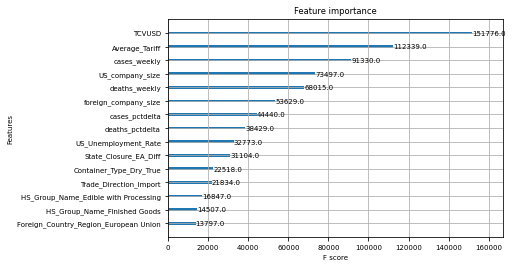

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGB_HPO_train19test20_300_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

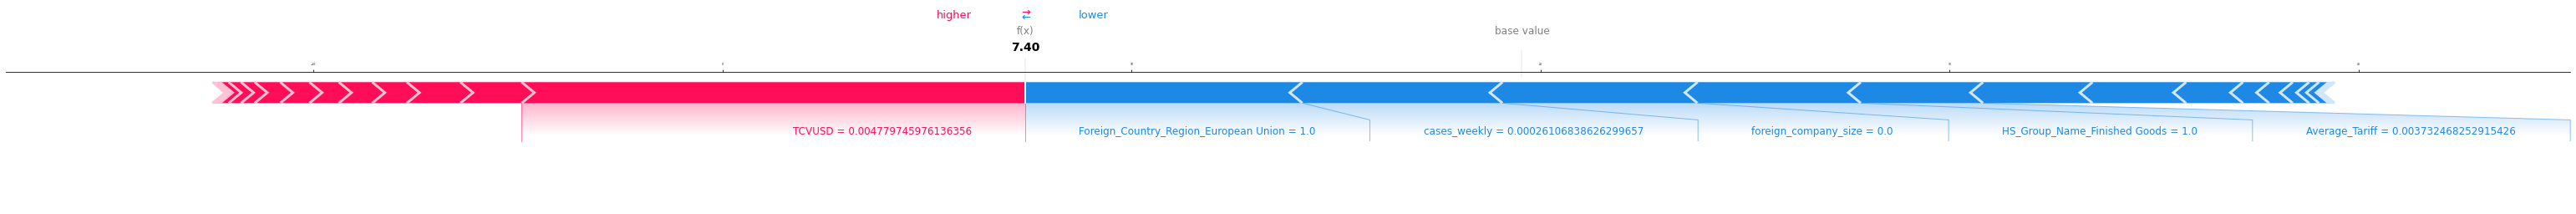

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_300_GPU_train19test20_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

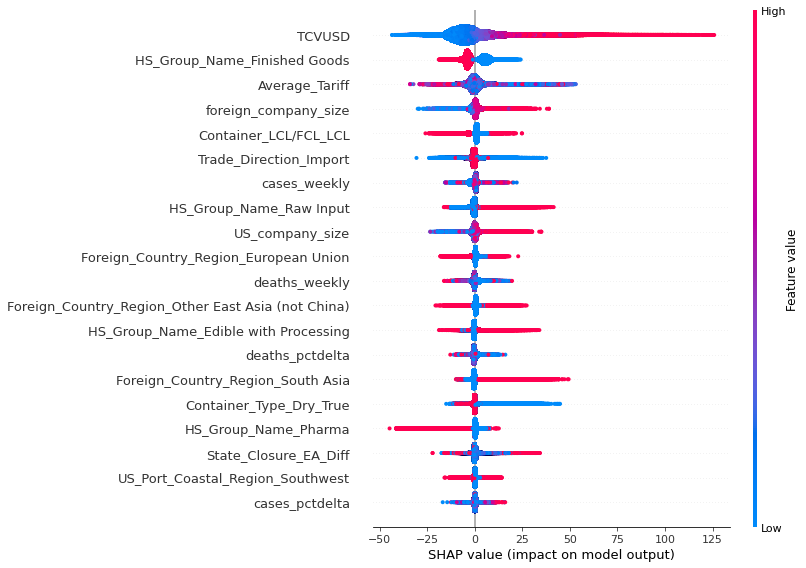

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train19test20_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)                                                                    

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train19test20_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train19test20_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train19test20_HPO_300_GPU_WeightsExplain.csv', 
           index=False)
exp

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  1.175018  0.000920
1                                      Average_Tariff  0.466860  0.000574
2                        HS_Group_Name_Finished Goods  0.198437  0.000098
3                              Trade_Direction_Import  0.173048  0.000313
4                                        cases_weekly  0.131556  0.000101
5                                     US_company_size  0.131106  0.000302
6                             HS_Group_Name_Raw Input  0.128781  0.000164
7                                foreign_company_size  0.113166  0.000196
8                                       deaths_weekly  0.101083  0.000156
9                                     deaths_pctdelta  0.076598  0.000206
10                              State_Closure_EA_Diff  0.067136  0.000178
11                            Container_Type_Dry_True  0.065480  0.000232
12              Foreign_Country_Region_European Union  0.060188  0.000052
13               HS_Group_Name_Edible with Processing  0.059842  0.000163
14                  Foreign_Country_Region_South Asia  0.059626  0.000235
15                                     cases_pctdelta  0.058749  0.000047
16  Foreign_Country_Region_Other East Asia (not Ch...  0.052132  0.000106
17                               HS_Group_Name_Pharma  0.041060  0.000107
18              Foreign_Country_Region_Southeast Asia  0.037339  0.000066
19                                HS_Group_Name_Vices  0.032145  0.000066